In [1]:
import sys
import os
# Add the scripts directory to the system path
sys.path.append(os.path.abspath('../scripts'))

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from data_preprocessing import preprocess_data, encode_categorical
from utils import calculate_imbalance_ratio, filter_noisy_samples
from plot_utils import plot_class_distribution, plot_confusion_matrix
from evaluation import calculate_metrics, calculate_error_rate_per_class, f1_score_per_class, ks_test, chi2_test
from data_augmentation import generate_synthetic_samples_ctgan, generate_synthetic_samples_wgangp

In [238]:
# Load data
file_path = "../datasets/telco_customer_churn.csv"
df = pd.read_csv(file_path)

## Data Loading and Preprocessing

In [239]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [240]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [242]:
# convert datatype for 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [243]:
discrete_columns = ['gender','SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                     'PaymentMethod', 'Churn' ]
continuous_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [244]:
# Dropping the "customerID" column
df.drop('customerID', axis=1, inplace=True)

In [245]:
# check null values
print(df.isna().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [246]:
df.dropna(subset=['TotalCharges'], inplace=True)

In [247]:
# Check for duplicate columns
duplicate_columns = df.columns.duplicated().sum()

print("Number of duplicate columns:", duplicate_columns)

Number of duplicate columns: 0


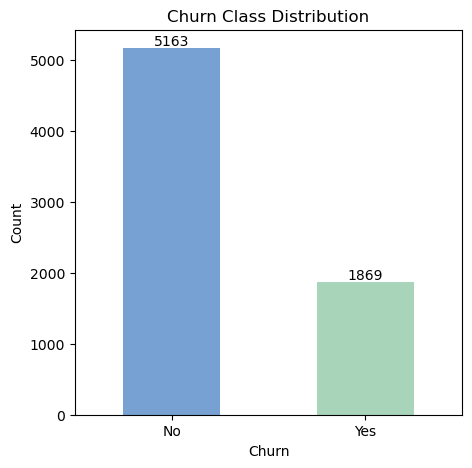

In [248]:
plot_class_distribution(df, 'Churn', title='Churn Class Distribution')

In [249]:
# Calculate imbalance ratio
imbalance_ratio, _, _, _, _ = calculate_imbalance_ratio(df, 'Churn')
print("Imbalance Ratio:", imbalance_ratio)

Imbalance Ratio: 2.7624398073836276


In [250]:
# Splitting the data into train and test sets with a 30:70 ratio
X_train, X_test, y_train, y_test = preprocess_data(df)
train_data = pd.concat([X_train, y_train], axis=1)

In [251]:
# Calculate imbalance ratio and class counts of training data
imbalance_ratio, majority_class, majority_class_count, minority_class, minority_class_count = calculate_imbalance_ratio(train_data, 'Churn')

# Print the results
print("Imbalance Ratio:", imbalance_ratio)
print("Majority Class:", majority_class)
print("Number of Instances in Majority Class:", majority_class_count)
print("Minority Class:", minority_class)
print("Number of Instances in Minority Class:", minority_class_count)


Imbalance Ratio: 2.7629969418960245
Majority Class: No
Number of Instances in Majority Class: 3614
Minority Class: Yes
Number of Instances in Minority Class: 1308


## Decision Tree Training with Original Data

In [252]:
# Encode categorical variables
X_train, encoded_labels = encode_categorical(X_train)
X_test, encoded_labels = encode_categorical(X_test)

In [253]:
# Train a decision tree classifier
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2', random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       random_state=42)

In [254]:
# Make predictions on the testing data
y_pred = tree_model.predict(X_test)

# Calculate metrics
metrics_df = calculate_metrics(y_test, y_pred)
metrics_df

,Score
Accuracy,0.784360
F1-score (macro),0.708001
Recall (macro),0.697937
Geometric Mean,0.673090
Cohen's Kappa,0.417470


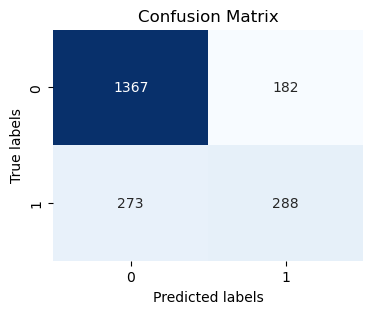

In [255]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [256]:
# Error rate per class
print('Error rate per class:')
print(calculate_error_rate_per_class(y_test, y_pred))

# Error rate per class
print('\nF1 score per class:')
print(f1_score_per_class(y_test, y_pred))

Error rate per class:
[0.11749516 0.48663102]

F1 score per class:
[0.85732204 0.55868089]


## Tabular Synthetic Data Generation with CTGAN

In [320]:
# Define the CTGAN model parameters
ctgan_args = ModelParameters(batch_size=50, lr=0.0001, betas=(0.5, 0.9))

# Define the training parameters
train_args = TrainParameters(epochs=200)

# Target column
target_column = 'Churn'

In [321]:
# Generate synthetic samples
augmented_train_data_ctgan, synth_data_ctgan = generate_synthetic_samples_ctgan(train_data, minority_class, majority_class_count, minority_class_count, ctgan_args, train_args, continuous_columns, discrete_columns, target_column)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Epoch: 0 | critic_loss: 4.687939643859863 | generator_loss: 0.9269081354141235
Epoch: 1 | critic_loss: 2.0983762741088867 | generator_loss: 0.792934775352478
Epoch: 2 | critic_loss: -0.34752988815307617 | generator_loss: 0.8356883525848389
Epoch: 3 | critic_loss: -0.17581158876419067 | generator_loss: 0.07291865348815918
Epoch: 4 | critic_loss: 0.6044237017631531 | generator_loss: -0.15078246593475342
Epoch: 5 | critic_loss: 0.6369391083717346 | generator_loss: 0.00854349136352539
Epoch: 6 | critic_loss: 0.4486277103424072 | generator_loss: 0.07236206531524658
Epoch: 7 | critic_loss: 0.21624158322811127 | generator_loss: -0.3596026301383972
Epoch: 8 | critic_loss: 0.37830060720443726 | generator_loss: -0.15873801708221436
Epoch: 9 | critic_loss: -0.02123105525970459 | generator_loss: -0.39536595344543457
Epoch: 10 | critic_loss: 0.45087406039237976 | generator_loss: -0.10265415906906128
Epoch: 11 | critic_loss: 0.020535457879304886 | generator_loss: -0.46023207902908325
Epoch: 12 | cri

In [261]:
minority_train_data = train_data[train_data[target_column] == minority_class]

In [262]:
# Perform KS Test
ks_results_df, average_ks_score = ks_test(synth_data_ctgan, minority_train_data, continuous_columns, target_column)
print("KS Test Average Score:", average_ks_score)

KS Test Average Score: 0.7496912278654363


In [3]:
# Perform Chi-Square Test
chi2_test_results_df, average_p_value = chi2_test(synth_data_ctgan, minority_train_data, discrete_columns, target_column)
print("Chi-Square Test Average P-value:", average_p_value)

Chi-Square Test Average P-value: 0.5017611940990859


In [264]:
X_train_augmented_ctgan = augmented_train_data_ctgan.drop('Churn', axis=1)  # Features (all columns except the target variable)
y_train_augmented_ctgan = augmented_train_data_ctgan['Churn']  # Target variable

# Encode categorical variables
X_train_augmented_ctgan, _ = encode_categorical(X_train_augmented_ctgan)

In [265]:
tree_model_ctgan = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, max_features = 'log2', random_state=42)
tree_model_ctgan.fit(X_train_augmented_ctgan, y_train_augmented_ctgan)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       random_state=42)

In [266]:
# Make predictions on the testing data
y_pred_ctgan = tree_model_ctgan.predict(X_test)

# Calculate metrics
metrics_df_ctgan = calculate_metrics(y_test, y_pred_ctgan)
metrics_df_ctgan

,Score
Accuracy,0.740284
F1-score (macro),0.701800
Recall (macro),0.732724
Geometric Mean,0.732546
Cohen's Kappa,0.411628


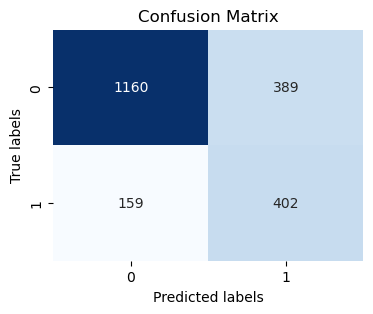

In [267]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_ctgan)

In [268]:
# Error rate per class
print('Error rate per class:')
print(calculate_error_rate_per_class(y_test, y_pred_ctgan))

# Error rate per class
print('\nF1 score per class:')
print(f1_score_per_class(y_test, y_pred_ctgan))

Error rate per class:
[0.25112976 0.28342246]

F1 score per class:
[0.80892608 0.59467456]


## Tabular Synthetic Data Generation with WGAN-GP

In [269]:
# Define the training parameters
noise_dim = 128
dim = 128
batch_size = 50

log_step = 100
epochs = 150
learning_rate = [5e-4, 5e-4]
beta_1 = 0.5
beta_2 = 0.9
n_critic = 5

In [270]:
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

In [322]:
# Generate synthetic samples
augmented_train_data_wgan, synth_data_wgan = generate_synthetic_samples_wgangp(
    train_data, minority_class, majority_class_count, minority_class_count,
    gan_args, train_args, continuous_columns, discrete_columns, target_column, n_critic
)

  0%|          | 1/200 [00:07<24:08,  7.28s/it]

Epoch: 0 | disc_loss: -0.12238870561122894 | gen_loss: 0.05679648742079735


  1%|          | 2/200 [00:07<11:15,  3.41s/it]

Epoch: 1 | disc_loss: -0.19591036438941956 | gen_loss: 0.08790668845176697


  2%|▏         | 3/200 [00:08<07:08,  2.18s/it]

Epoch: 2 | disc_loss: -0.2342248409986496 | gen_loss: 0.07376128435134888


  2%|▏         | 4/200 [00:09<05:13,  1.60s/it]

Epoch: 3 | disc_loss: -0.2301453799009323 | gen_loss: 0.13794711232185364


  2%|▎         | 5/200 [00:10<04:09,  1.28s/it]

Epoch: 4 | disc_loss: -0.2342466562986374 | gen_loss: 0.12793944776058197


  3%|▎         | 6/200 [00:10<03:30,  1.09s/it]

Epoch: 5 | disc_loss: -0.06583218276500702 | gen_loss: 0.10319746285676956


  4%|▎         | 7/200 [00:11<03:02,  1.06it/s]

Epoch: 6 | disc_loss: -0.2563168704509735 | gen_loss: 0.087148018181324


  4%|▍         | 8/200 [00:11<02:29,  1.28it/s]

Epoch: 7 | disc_loss: -0.12400603294372559 | gen_loss: 0.134707972407341


  4%|▍         | 9/200 [00:12<02:13,  1.43it/s]

Epoch: 8 | disc_loss: -0.10138416290283203 | gen_loss: 0.12936876714229584


  5%|▌         | 10/200 [00:13<02:10,  1.46it/s]

Epoch: 9 | disc_loss: -0.1923706829547882 | gen_loss: 0.16332638263702393


  6%|▌         | 11/200 [00:13<02:02,  1.55it/s]

Epoch: 10 | disc_loss: -0.2649684548377991 | gen_loss: 0.040475405752658844


  6%|▌         | 12/200 [00:14<01:59,  1.58it/s]

Epoch: 11 | disc_loss: -0.2467319220304489 | gen_loss: 0.07795251905918121


  6%|▋         | 13/200 [00:14<01:57,  1.59it/s]

Epoch: 12 | disc_loss: -0.2567184865474701 | gen_loss: 0.0901259034872055


  7%|▋         | 14/200 [00:15<01:56,  1.60it/s]

Epoch: 13 | disc_loss: -0.23224499821662903 | gen_loss: 0.08769252896308899


  8%|▊         | 15/200 [00:16<01:55,  1.60it/s]

Epoch: 14 | disc_loss: -0.2674017548561096 | gen_loss: 0.07271759957075119


  8%|▊         | 16/200 [00:16<01:59,  1.54it/s]

Epoch: 15 | disc_loss: -0.24977821111679077 | gen_loss: 0.10040326416492462


  8%|▊         | 17/200 [00:17<01:55,  1.59it/s]

Epoch: 16 | disc_loss: -0.25521931052207947 | gen_loss: 0.12831245362758636


  9%|▉         | 18/200 [00:18<01:58,  1.54it/s]

Epoch: 17 | disc_loss: -0.2431865632534027 | gen_loss: 0.11522169411182404


 10%|▉         | 19/200 [00:18<02:01,  1.50it/s]

Epoch: 18 | disc_loss: -0.2500300407409668 | gen_loss: 0.0927082747220993


 10%|█         | 20/200 [00:19<02:02,  1.46it/s]

Epoch: 19 | disc_loss: -0.22766858339309692 | gen_loss: 0.0942811518907547


 10%|█         | 21/200 [00:20<02:03,  1.44it/s]

Epoch: 20 | disc_loss: -0.22666876018047333 | gen_loss: 0.10908237099647522


 11%|█         | 22/200 [00:20<02:04,  1.43it/s]

Epoch: 21 | disc_loss: -0.2621608376502991 | gen_loss: 0.08813896775245667


 12%|█▏        | 23/200 [00:21<02:01,  1.46it/s]

Epoch: 22 | disc_loss: -0.24982155859470367 | gen_loss: 0.0879523977637291


 12%|█▏        | 24/200 [00:22<01:54,  1.54it/s]

Epoch: 23 | disc_loss: -0.1985953152179718 | gen_loss: 0.09541258960962296


 12%|█▎        | 25/200 [00:22<01:52,  1.55it/s]

Epoch: 24 | disc_loss: -0.14849182963371277 | gen_loss: 0.08957991003990173


 13%|█▎        | 26/200 [00:23<01:51,  1.56it/s]

Epoch: 25 | disc_loss: -0.1544252336025238 | gen_loss: 0.04598471149802208


 14%|█▎        | 27/200 [00:24<01:49,  1.59it/s]

Epoch: 26 | disc_loss: -0.22769318521022797 | gen_loss: 0.07051017880439758


 14%|█▍        | 28/200 [00:24<01:47,  1.60it/s]

Epoch: 27 | disc_loss: -0.21060679852962494 | gen_loss: 0.0577172227203846


 14%|█▍        | 29/200 [00:25<01:45,  1.62it/s]

Epoch: 28 | disc_loss: -0.24153214693069458 | gen_loss: 0.046883903443813324


 15%|█▌        | 30/200 [00:25<01:43,  1.64it/s]

Epoch: 29 | disc_loss: -0.24915218353271484 | gen_loss: 0.07018020749092102


 16%|█▌        | 31/200 [00:26<01:44,  1.62it/s]

Epoch: 30 | disc_loss: -0.23738083243370056 | gen_loss: 0.0409311018884182


 16%|█▌        | 32/200 [00:27<01:48,  1.55it/s]

Epoch: 31 | disc_loss: -0.2452906370162964 | gen_loss: 0.09280382841825485


 16%|█▋        | 33/200 [00:27<01:50,  1.52it/s]

Epoch: 32 | disc_loss: -0.18767228722572327 | gen_loss: 0.0504985935986042


 17%|█▋        | 34/200 [00:28<01:51,  1.49it/s]

Epoch: 33 | disc_loss: -0.23498110473155975 | gen_loss: 0.0622587576508522


 18%|█▊        | 35/200 [00:29<01:53,  1.46it/s]

Epoch: 34 | disc_loss: -0.23080149292945862 | gen_loss: 0.05583999678492546


 18%|█▊        | 36/200 [00:30<01:53,  1.44it/s]

Epoch: 35 | disc_loss: -0.21387013792991638 | gen_loss: 0.07059208303689957


 18%|█▊        | 37/200 [00:30<01:54,  1.43it/s]

Epoch: 36 | disc_loss: -0.20638106763362885 | gen_loss: 0.07460686564445496


 19%|█▉        | 38/200 [00:31<01:54,  1.42it/s]

Epoch: 37 | disc_loss: -0.22831867635250092 | gen_loss: 0.03290032595396042


 20%|█▉        | 39/200 [00:32<01:50,  1.46it/s]

Epoch: 38 | disc_loss: -0.14960986375808716 | gen_loss: 0.04504203423857689


 20%|██        | 40/200 [00:32<01:45,  1.51it/s]

Epoch: 39 | disc_loss: -0.11082696914672852 | gen_loss: 0.02385059744119644


 20%|██        | 41/200 [00:33<01:42,  1.55it/s]

Epoch: 40 | disc_loss: -0.22781360149383545 | gen_loss: 0.05383412539958954


 21%|██        | 42/200 [00:33<01:38,  1.60it/s]

Epoch: 41 | disc_loss: -0.24514074623584747 | gen_loss: 0.043496325612068176


 22%|██▏       | 43/200 [00:34<01:37,  1.61it/s]

Epoch: 42 | disc_loss: -0.21887457370758057 | gen_loss: 0.04374481365084648


 22%|██▏       | 44/200 [00:35<01:35,  1.64it/s]

Epoch: 43 | disc_loss: -0.22202645242214203 | gen_loss: 0.03407493978738785


 22%|██▎       | 45/200 [00:35<01:34,  1.65it/s]

Epoch: 44 | disc_loss: -0.21128684282302856 | gen_loss: 0.021335944533348083


 23%|██▎       | 46/200 [00:36<01:32,  1.66it/s]

Epoch: 45 | disc_loss: -0.22675903141498566 | gen_loss: 0.009046579711139202


 24%|██▎       | 47/200 [00:36<01:35,  1.59it/s]

Epoch: 46 | disc_loss: -0.22667938470840454 | gen_loss: 0.0288349911570549


 24%|██▍       | 48/200 [00:37<01:39,  1.53it/s]

Epoch: 47 | disc_loss: -0.20849594473838806 | gen_loss: 0.03891069069504738


 24%|██▍       | 49/200 [00:38<01:41,  1.49it/s]

Epoch: 48 | disc_loss: -0.21700695157051086 | gen_loss: 0.019911009818315506


 25%|██▌       | 50/200 [00:39<01:42,  1.47it/s]

Epoch: 49 | disc_loss: -0.20646202564239502 | gen_loss: 0.003369559533894062


 26%|██▌       | 51/200 [00:39<01:44,  1.42it/s]

Epoch: 50 | disc_loss: -0.22692565619945526 | gen_loss: 0.010152315720915794


 26%|██▌       | 52/200 [00:40<01:45,  1.40it/s]

Epoch: 51 | disc_loss: -0.21200694143772125 | gen_loss: 0.00011265404464211315


 26%|██▋       | 53/200 [00:41<01:44,  1.40it/s]

Epoch: 52 | disc_loss: -0.2016279548406601 | gen_loss: 0.01948428712785244


 27%|██▋       | 54/200 [00:41<01:33,  1.56it/s]

Epoch: 53 | disc_loss: -0.19587799906730652 | gen_loss: -0.017442649230360985


 28%|██▊       | 55/200 [00:42<01:32,  1.57it/s]

Epoch: 54 | disc_loss: -0.21123461425304413 | gen_loss: -0.008172376081347466


 28%|██▊       | 56/200 [00:43<01:31,  1.58it/s]

Epoch: 55 | disc_loss: -0.10998640954494476 | gen_loss: 0.012067019008100033


 28%|██▊       | 57/200 [00:43<01:29,  1.60it/s]

Epoch: 56 | disc_loss: -0.16832639276981354 | gen_loss: 0.0019465716322883964


 29%|██▉       | 58/200 [00:44<01:28,  1.60it/s]

Epoch: 57 | disc_loss: -0.18166719377040863 | gen_loss: -0.027792297303676605


 30%|██▉       | 59/200 [00:44<01:19,  1.78it/s]

Epoch: 58 | disc_loss: -0.16297930479049683 | gen_loss: 0.03352152928709984


 30%|███       | 60/200 [00:45<01:17,  1.81it/s]

Epoch: 59 | disc_loss: -0.18777136504650116 | gen_loss: -0.0006878416170366108


 30%|███       | 61/200 [00:45<01:19,  1.75it/s]

Epoch: 60 | disc_loss: -0.19008471071720123 | gen_loss: -0.01800738088786602


 31%|███       | 62/200 [00:46<01:20,  1.71it/s]

Epoch: 61 | disc_loss: -0.20727834105491638 | gen_loss: 0.002541592810302973


 32%|███▏      | 63/200 [00:47<01:22,  1.65it/s]

Epoch: 62 | disc_loss: -0.19556733965873718 | gen_loss: 0.010691629722714424


 32%|███▏      | 64/200 [00:47<01:26,  1.57it/s]

Epoch: 63 | disc_loss: -0.22129148244857788 | gen_loss: -0.028052007779479027


 32%|███▎      | 65/200 [00:48<01:28,  1.52it/s]

Epoch: 64 | disc_loss: -0.18490126729011536 | gen_loss: 0.0050912583246827126


 33%|███▎      | 66/200 [00:49<01:28,  1.51it/s]

Epoch: 65 | disc_loss: -0.06743234395980835 | gen_loss: -0.023187780752778053


 34%|███▎      | 67/200 [00:49<01:29,  1.48it/s]

Epoch: 66 | disc_loss: -0.13086643815040588 | gen_loss: -0.011895721778273582


 34%|███▍      | 68/200 [00:50<01:30,  1.46it/s]

Epoch: 67 | disc_loss: -0.2028351128101349 | gen_loss: 0.005323329474776983


 34%|███▍      | 69/200 [00:51<01:30,  1.44it/s]

Epoch: 68 | disc_loss: -0.13033375144004822 | gen_loss: -0.004511892329901457


 35%|███▌      | 70/200 [00:51<01:28,  1.46it/s]

Epoch: 69 | disc_loss: -0.21380715072155 | gen_loss: 0.005433108191937208


 36%|███▌      | 71/200 [00:52<01:24,  1.52it/s]

Epoch: 70 | disc_loss: -0.2075754702091217 | gen_loss: -0.017092369496822357


 36%|███▌      | 72/200 [00:53<01:22,  1.55it/s]

Epoch: 71 | disc_loss: -0.18065981566905975 | gen_loss: -0.011746185831725597


 36%|███▋      | 73/200 [00:53<01:20,  1.57it/s]

Epoch: 72 | disc_loss: -0.20299944281578064 | gen_loss: -0.017350420355796814


 37%|███▋      | 74/200 [00:54<01:18,  1.60it/s]

Epoch: 73 | disc_loss: -0.19284886121749878 | gen_loss: -0.0016286054160445929


 38%|███▊      | 75/200 [00:54<01:17,  1.61it/s]

Epoch: 74 | disc_loss: -0.1731683611869812 | gen_loss: -0.020358173176646233


 38%|███▊      | 76/200 [00:55<01:17,  1.61it/s]

Epoch: 75 | disc_loss: -0.15677109360694885 | gen_loss: -0.019649440422654152


 38%|███▊      | 77/200 [00:56<01:16,  1.61it/s]

Epoch: 76 | disc_loss: -0.17598365247249603 | gen_loss: -0.021163981407880783


 39%|███▉      | 78/200 [00:56<01:16,  1.59it/s]

Epoch: 77 | disc_loss: -0.20144066214561462 | gen_loss: -0.01822863705456257


 40%|███▉      | 79/200 [00:57<01:18,  1.54it/s]

Epoch: 78 | disc_loss: -0.1120966374874115 | gen_loss: -0.03614538908004761


 40%|████      | 80/200 [00:58<01:20,  1.49it/s]

Epoch: 79 | disc_loss: 0.0023469626903533936 | gen_loss: -0.04297842085361481


 40%|████      | 81/200 [00:58<01:20,  1.48it/s]

Epoch: 80 | disc_loss: -0.19680161774158478 | gen_loss: -0.03281718119978905


 41%|████      | 82/200 [00:59<01:21,  1.45it/s]

Epoch: 81 | disc_loss: -0.176112100481987 | gen_loss: 0.004383412189781666


 42%|████▏     | 83/200 [01:00<01:21,  1.44it/s]

Epoch: 82 | disc_loss: -0.17670172452926636 | gen_loss: -0.046662285923957825


 42%|████▏     | 84/200 [01:01<01:21,  1.42it/s]

Epoch: 83 | disc_loss: -0.17767846584320068 | gen_loss: -0.03547064960002899


 42%|████▎     | 85/200 [01:01<01:20,  1.42it/s]

Epoch: 84 | disc_loss: -0.19678539037704468 | gen_loss: -0.030558323487639427


 43%|████▎     | 86/200 [01:02<01:18,  1.45it/s]

Epoch: 85 | disc_loss: -0.16217410564422607 | gen_loss: -0.04306185618042946


 44%|████▎     | 87/200 [01:03<01:14,  1.51it/s]

Epoch: 86 | disc_loss: -0.1831134408712387 | gen_loss: -0.030059561133384705


 44%|████▍     | 88/200 [01:03<01:12,  1.54it/s]

Epoch: 87 | disc_loss: -0.13423994183540344 | gen_loss: -0.051572490483522415


 44%|████▍     | 89/200 [01:04<01:10,  1.58it/s]

Epoch: 88 | disc_loss: -0.1717546582221985 | gen_loss: -0.016903620213270187


 45%|████▌     | 90/200 [01:04<01:07,  1.63it/s]

Epoch: 89 | disc_loss: -0.18333648145198822 | gen_loss: -0.05226192995905876


 46%|████▌     | 91/200 [01:05<01:06,  1.65it/s]

Epoch: 90 | disc_loss: -0.17397533357143402 | gen_loss: -0.034463826566934586


 46%|████▌     | 92/200 [01:05<01:03,  1.71it/s]

Epoch: 91 | disc_loss: -0.17335475981235504 | gen_loss: -0.014395352452993393


 46%|████▋     | 93/200 [01:06<01:00,  1.76it/s]

Epoch: 92 | disc_loss: -0.1383432149887085 | gen_loss: -0.04840937629342079


 47%|████▋     | 94/200 [01:07<00:57,  1.83it/s]

Epoch: 93 | disc_loss: -0.09607946872711182 | gen_loss: -0.05561404302716255


 48%|████▊     | 95/200 [01:07<01:02,  1.69it/s]

Epoch: 94 | disc_loss: -0.17588858306407928 | gen_loss: -0.02517635188996792


 48%|████▊     | 96/200 [01:08<01:05,  1.60it/s]

Epoch: 95 | disc_loss: -0.18382136523723602 | gen_loss: -0.041433047503232956


 48%|████▊     | 97/200 [01:09<01:06,  1.54it/s]

Epoch: 96 | disc_loss: -0.0908309742808342 | gen_loss: -0.05582331493496895


 49%|████▉     | 98/200 [01:09<01:08,  1.50it/s]

Epoch: 97 | disc_loss: -0.14984950423240662 | gen_loss: -0.03362337499856949


 50%|████▉     | 99/200 [01:10<01:09,  1.46it/s]

Epoch: 98 | disc_loss: -0.16892772912979126 | gen_loss: -0.04727450758218765


 50%|█████     | 100/200 [01:11<01:08,  1.45it/s]

Epoch: 99 | disc_loss: -0.1566285789012909 | gen_loss: -0.041252635419368744


 50%|█████     | 101/200 [01:12<01:10,  1.41it/s]

Epoch: 100 | disc_loss: -0.08599267899990082 | gen_loss: -0.04286233335733414


 51%|█████     | 102/200 [01:12<01:08,  1.44it/s]

Epoch: 101 | disc_loss: -0.1460525095462799 | gen_loss: -0.05256412550806999


 52%|█████▏    | 103/200 [01:13<01:03,  1.52it/s]

Epoch: 102 | disc_loss: -0.1663462519645691 | gen_loss: -0.04940158501267433


 52%|█████▏    | 104/200 [01:13<00:56,  1.71it/s]

Epoch: 103 | disc_loss: -0.13981063663959503 | gen_loss: -0.03874963894486427


 52%|█████▎    | 105/200 [01:14<00:53,  1.78it/s]

Epoch: 104 | disc_loss: -0.18519680202007294 | gen_loss: -0.0368555448949337


 53%|█████▎    | 106/200 [01:14<00:54,  1.73it/s]

Epoch: 105 | disc_loss: -0.19696635007858276 | gen_loss: -0.03612576052546501


 54%|█████▎    | 107/200 [01:15<00:55,  1.67it/s]

Epoch: 106 | disc_loss: -0.16889320313930511 | gen_loss: -0.029658474028110504


 54%|█████▍    | 108/200 [01:16<00:54,  1.67it/s]

Epoch: 107 | disc_loss: -0.10230752825737 | gen_loss: -0.032123394310474396


 55%|█████▍    | 109/200 [01:16<00:55,  1.65it/s]

Epoch: 108 | disc_loss: -0.060702621936798096 | gen_loss: -0.042886458337306976


 55%|█████▌    | 110/200 [01:17<00:55,  1.61it/s]

Epoch: 109 | disc_loss: -0.16605019569396973 | gen_loss: -0.05202991142868996


 56%|█████▌    | 111/200 [01:18<00:57,  1.55it/s]

Epoch: 110 | disc_loss: -0.10647090524435043 | gen_loss: -0.032804250717163086


 56%|█████▌    | 112/200 [01:18<00:58,  1.51it/s]

Epoch: 111 | disc_loss: -0.14959335327148438 | gen_loss: -0.02444721944630146


 56%|█████▋    | 113/200 [01:19<00:56,  1.53it/s]

Epoch: 112 | disc_loss: -0.1780148595571518 | gen_loss: -0.0522545762360096


 57%|█████▋    | 114/200 [01:20<00:57,  1.50it/s]

Epoch: 113 | disc_loss: -0.16180269420146942 | gen_loss: -0.07621666043996811


 57%|█████▊    | 115/200 [01:20<00:57,  1.48it/s]

Epoch: 114 | disc_loss: -0.08453668653964996 | gen_loss: -0.05238894373178482


 58%|█████▊    | 116/200 [01:21<00:57,  1.47it/s]

Epoch: 115 | disc_loss: -0.15068991482257843 | gen_loss: -0.039429958909749985


 58%|█████▊    | 117/200 [01:22<00:56,  1.46it/s]

Epoch: 116 | disc_loss: -0.14785261452198029 | gen_loss: -0.02733812853693962


 59%|█████▉    | 118/200 [01:22<00:55,  1.48it/s]

Epoch: 117 | disc_loss: 0.005981162190437317 | gen_loss: -0.056872863322496414


 60%|█████▉    | 119/200 [01:23<00:52,  1.55it/s]

Epoch: 118 | disc_loss: -0.171138733625412 | gen_loss: -0.05835128203034401


 60%|██████    | 120/200 [01:23<00:50,  1.58it/s]

Epoch: 119 | disc_loss: -0.15122945606708527 | gen_loss: -0.05444050952792168


 60%|██████    | 121/200 [01:24<00:49,  1.61it/s]

Epoch: 120 | disc_loss: -0.05294981598854065 | gen_loss: -0.05161856487393379


 61%|██████    | 122/200 [01:25<00:48,  1.62it/s]

Epoch: 121 | disc_loss: -0.1492944359779358 | gen_loss: -0.054957419633865356


 62%|██████▏   | 123/200 [01:25<00:47,  1.62it/s]

Epoch: 122 | disc_loss: -0.15835241973400116 | gen_loss: -0.05216659978032112


 62%|██████▏   | 124/200 [01:26<00:46,  1.65it/s]

Epoch: 123 | disc_loss: -0.15549211204051971 | gen_loss: -0.0611095130443573


 62%|██████▎   | 125/200 [01:26<00:44,  1.67it/s]

Epoch: 124 | disc_loss: -0.16126872599124908 | gen_loss: -0.05188252031803131


 63%|██████▎   | 126/200 [01:27<00:45,  1.63it/s]

Epoch: 125 | disc_loss: -0.15044640004634857 | gen_loss: -0.04779414087533951


 64%|██████▎   | 127/200 [01:28<00:46,  1.55it/s]

Epoch: 126 | disc_loss: -0.15648147463798523 | gen_loss: -0.033962398767471313


 64%|██████▍   | 128/200 [01:28<00:46,  1.54it/s]

Epoch: 127 | disc_loss: -0.11846302449703217 | gen_loss: -0.08845999091863632


 64%|██████▍   | 129/200 [01:29<00:47,  1.50it/s]

Epoch: 128 | disc_loss: -0.1603025496006012 | gen_loss: -0.07272066920995712


 65%|██████▌   | 130/200 [01:30<00:47,  1.47it/s]

Epoch: 129 | disc_loss: -0.16839410364627838 | gen_loss: -0.06658192723989487


 66%|██████▌   | 131/200 [01:31<00:47,  1.46it/s]

Epoch: 130 | disc_loss: -0.13686290383338928 | gen_loss: -0.046823274344205856


 66%|██████▌   | 132/200 [01:31<00:45,  1.48it/s]

Epoch: 131 | disc_loss: -0.1615007370710373 | gen_loss: -0.0654231384396553


 66%|██████▋   | 133/200 [01:32<00:41,  1.63it/s]

Epoch: 132 | disc_loss: -0.16430258750915527 | gen_loss: -0.07615300267934799


 67%|██████▋   | 134/200 [01:32<00:39,  1.67it/s]

Epoch: 133 | disc_loss: -0.1557866781949997 | gen_loss: -0.04265410080552101


 68%|██████▊   | 135/200 [01:33<00:39,  1.67it/s]

Epoch: 134 | disc_loss: -0.12516212463378906 | gen_loss: -0.047998491674661636


 68%|██████▊   | 136/200 [01:33<00:38,  1.67it/s]

Epoch: 135 | disc_loss: -0.10959559679031372 | gen_loss: -0.06466749310493469


 68%|██████▊   | 137/200 [01:34<00:37,  1.67it/s]

Epoch: 136 | disc_loss: -0.14704525470733643 | gen_loss: -0.06348539143800735


 69%|██████▉   | 138/200 [01:35<00:36,  1.68it/s]

Epoch: 137 | disc_loss: -0.15346038341522217 | gen_loss: -0.07497113943099976


 70%|██████▉   | 139/200 [01:35<00:36,  1.69it/s]

Epoch: 138 | disc_loss: -0.15876780450344086 | gen_loss: -0.07972551137208939


 70%|███████   | 140/200 [01:36<00:35,  1.71it/s]

Epoch: 139 | disc_loss: -0.13436150550842285 | gen_loss: -0.05113476142287254


 70%|███████   | 141/200 [01:36<00:34,  1.70it/s]

Epoch: 140 | disc_loss: -0.14383381605148315 | gen_loss: -0.08319468796253204


 71%|███████   | 142/200 [01:37<00:31,  1.86it/s]

Epoch: 141 | disc_loss: -0.13764835894107819 | gen_loss: -0.052272602915763855


 72%|███████▏  | 143/200 [01:37<00:30,  1.87it/s]

Epoch: 142 | disc_loss: -0.09782352298498154 | gen_loss: -0.04386952891945839


 72%|███████▏  | 144/200 [01:38<00:32,  1.71it/s]

Epoch: 143 | disc_loss: -0.14917734265327454 | gen_loss: -0.060670312494039536


 72%|███████▎  | 145/200 [01:39<00:34,  1.62it/s]

Epoch: 144 | disc_loss: -0.14419884979724884 | gen_loss: -0.05189858004450798


 73%|███████▎  | 146/200 [01:39<00:34,  1.56it/s]

Epoch: 145 | disc_loss: -0.13783502578735352 | gen_loss: -0.07320751994848251


 74%|███████▎  | 147/200 [01:40<00:34,  1.52it/s]

Epoch: 146 | disc_loss: -0.1193334311246872 | gen_loss: -0.06267672777175903


 74%|███████▍  | 148/200 [01:41<00:35,  1.48it/s]

Epoch: 147 | disc_loss: -0.15201614797115326 | gen_loss: -0.07317528128623962


 74%|███████▍  | 149/200 [01:42<00:35,  1.45it/s]

Epoch: 148 | disc_loss: -0.15138359367847443 | gen_loss: -0.06779251247644424


 75%|███████▌  | 150/200 [01:42<00:34,  1.44it/s]

Epoch: 149 | disc_loss: -0.13832314312458038 | gen_loss: -0.07324328273534775


 76%|███████▌  | 151/200 [01:43<00:31,  1.54it/s]

Epoch: 150 | disc_loss: -0.1221141368150711 | gen_loss: -0.07794207334518433


 76%|███████▌  | 152/200 [01:43<00:30,  1.56it/s]

Epoch: 151 | disc_loss: -0.13762158155441284 | gen_loss: -0.07719585299491882


 76%|███████▋  | 153/200 [01:44<00:28,  1.65it/s]

Epoch: 152 | disc_loss: -0.15358342230319977 | gen_loss: -0.05228386074304581


 77%|███████▋  | 154/200 [01:45<00:27,  1.64it/s]

Epoch: 153 | disc_loss: -0.15293465554714203 | gen_loss: -0.06895620375871658


 78%|███████▊  | 155/200 [01:45<00:27,  1.64it/s]

Epoch: 154 | disc_loss: -0.1569284349679947 | gen_loss: -0.059003133326768875


 78%|███████▊  | 156/200 [01:46<00:26,  1.67it/s]

Epoch: 155 | disc_loss: -0.1542019248008728 | gen_loss: -0.07792022079229355


 78%|███████▊  | 157/200 [01:46<00:25,  1.66it/s]

Epoch: 156 | disc_loss: -0.1521637737751007 | gen_loss: -0.052463121712207794


 79%|███████▉  | 158/200 [01:47<00:25,  1.65it/s]

Epoch: 157 | disc_loss: -0.14224663376808167 | gen_loss: -0.05783725902438164


 80%|███████▉  | 159/200 [01:48<00:25,  1.58it/s]

Epoch: 158 | disc_loss: -0.12569721043109894 | gen_loss: -0.04968470707535744


 80%|████████  | 160/200 [01:48<00:26,  1.53it/s]

Epoch: 159 | disc_loss: -0.09334428608417511 | gen_loss: -0.0979127511382103


 80%|████████  | 161/200 [01:49<00:26,  1.49it/s]

Epoch: 160 | disc_loss: -0.14001794159412384 | gen_loss: -0.04215969517827034


 81%|████████  | 162/200 [01:50<00:25,  1.47it/s]

Epoch: 161 | disc_loss: -0.13410907983779907 | gen_loss: -0.053000565618276596


 82%|████████▏ | 163/200 [01:51<00:25,  1.45it/s]

Epoch: 162 | disc_loss: -0.14961956441402435 | gen_loss: -0.08174007385969162


 82%|████████▏ | 164/200 [01:51<00:25,  1.43it/s]

Epoch: 163 | disc_loss: -0.08735519647598267 | gen_loss: -0.058538611978292465


 82%|████████▎ | 165/200 [01:52<00:24,  1.43it/s]

Epoch: 164 | disc_loss: -0.16030387580394745 | gen_loss: -0.08572985976934433


 83%|████████▎ | 166/200 [01:53<00:23,  1.45it/s]

Epoch: 165 | disc_loss: -0.1395016312599182 | gen_loss: -0.08225757628679276


 84%|████████▎ | 167/200 [01:53<00:21,  1.52it/s]

Epoch: 166 | disc_loss: -0.13799484074115753 | gen_loss: -0.07159271836280823


 84%|████████▍ | 168/200 [01:54<00:20,  1.59it/s]

Epoch: 167 | disc_loss: -0.14834441244602203 | gen_loss: -0.09039095789194107


 84%|████████▍ | 169/200 [01:54<00:17,  1.72it/s]

Epoch: 168 | disc_loss: -0.15175940096378326 | gen_loss: -0.10615921765565872


 85%|████████▌ | 170/200 [01:55<00:17,  1.69it/s]

Epoch: 169 | disc_loss: -0.12088706344366074 | gen_loss: -0.06606784462928772


 86%|████████▌ | 171/200 [01:55<00:17,  1.67it/s]

Epoch: 170 | disc_loss: -0.14558207988739014 | gen_loss: -0.07088901847600937


 86%|████████▌ | 172/200 [01:56<00:16,  1.69it/s]

Epoch: 171 | disc_loss: -0.16768614947795868 | gen_loss: -0.08054910600185394


 86%|████████▋ | 173/200 [01:56<00:14,  1.80it/s]

Epoch: 172 | disc_loss: -0.1358821541070938 | gen_loss: -0.07866489887237549


 87%|████████▋ | 174/200 [01:57<00:13,  1.93it/s]

Epoch: 173 | disc_loss: -0.15028239786624908 | gen_loss: -0.08021070808172226


 88%|████████▊ | 175/200 [01:58<00:13,  1.85it/s]

Epoch: 174 | disc_loss: -0.135461688041687 | gen_loss: -0.08090914040803909


 88%|████████▊ | 176/200 [01:58<00:14,  1.71it/s]

Epoch: 175 | disc_loss: -0.12013574689626694 | gen_loss: -0.07027105987071991


 88%|████████▊ | 177/200 [01:59<00:11,  1.93it/s]

Epoch: 176 | disc_loss: -0.15572692453861237 | gen_loss: -0.05826662853360176


 89%|████████▉ | 178/200 [01:59<00:10,  2.00it/s]

Epoch: 177 | disc_loss: -0.1600363850593567 | gen_loss: -0.07067909836769104


 90%|████████▉ | 179/200 [02:00<00:11,  1.80it/s]

Epoch: 178 | disc_loss: -0.1503782570362091 | gen_loss: -0.0855187401175499


 90%|█████████ | 180/200 [02:00<00:12,  1.66it/s]

Epoch: 179 | disc_loss: -0.13575157523155212 | gen_loss: -0.05436643958091736


 90%|█████████ | 181/200 [02:01<00:11,  1.63it/s]

Epoch: 180 | disc_loss: -0.15344423055648804 | gen_loss: -0.05939062684774399


 91%|█████████ | 182/200 [02:02<00:11,  1.55it/s]

Epoch: 181 | disc_loss: -0.13649120926856995 | gen_loss: -0.10554184019565582


 92%|█████████▏| 183/200 [02:03<00:11,  1.50it/s]

Epoch: 182 | disc_loss: -0.10329408943653107 | gen_loss: -0.06109935790300369


 92%|█████████▏| 184/200 [02:03<00:10,  1.53it/s]

Epoch: 183 | disc_loss: -0.16832345724105835 | gen_loss: -0.06861865520477295


 92%|█████████▎| 185/200 [02:04<00:09,  1.57it/s]

Epoch: 184 | disc_loss: -0.13955143094062805 | gen_loss: -0.06396463513374329


 93%|█████████▎| 186/200 [02:04<00:08,  1.59it/s]

Epoch: 185 | disc_loss: -0.08656162023544312 | gen_loss: -0.0455651581287384


 94%|█████████▎| 187/200 [02:05<00:07,  1.64it/s]

Epoch: 186 | disc_loss: -0.1285208910703659 | gen_loss: -0.08507568389177322


 94%|█████████▍| 188/200 [02:06<00:07,  1.64it/s]

Epoch: 187 | disc_loss: -0.06720709800720215 | gen_loss: -0.04343270882964134


 94%|█████████▍| 189/200 [02:06<00:06,  1.65it/s]

Epoch: 188 | disc_loss: -0.12172480672597885 | gen_loss: -0.07224509119987488


 95%|█████████▌| 190/200 [02:07<00:05,  1.70it/s]

Epoch: 189 | disc_loss: -0.030128106474876404 | gen_loss: -0.05867569148540497


 96%|█████████▌| 191/200 [02:07<00:05,  1.66it/s]

Epoch: 190 | disc_loss: -0.12155884504318237 | gen_loss: -0.08520211279392242


 96%|█████████▌| 192/200 [02:08<00:04,  1.78it/s]

Epoch: 191 | disc_loss: -0.14164093136787415 | gen_loss: -0.06472110003232956


 96%|█████████▋| 193/200 [02:08<00:04,  1.70it/s]

Epoch: 192 | disc_loss: -0.09381242096424103 | gen_loss: -0.088422030210495


 97%|█████████▋| 194/200 [02:09<00:03,  1.62it/s]

Epoch: 193 | disc_loss: -0.11901481449604034 | gen_loss: -0.09566009789705276


 98%|█████████▊| 195/200 [02:10<00:03,  1.55it/s]

Epoch: 194 | disc_loss: -0.14705081284046173 | gen_loss: -0.09077457338571548


 98%|█████████▊| 196/200 [02:10<00:02,  1.52it/s]

Epoch: 195 | disc_loss: -0.12731324136257172 | gen_loss: -0.0790724828839302


 98%|█████████▊| 197/200 [02:11<00:02,  1.49it/s]

Epoch: 196 | disc_loss: -0.1769663393497467 | gen_loss: -0.1038999855518341


 99%|█████████▉| 198/200 [02:12<00:01,  1.48it/s]

Epoch: 197 | disc_loss: -0.15562154352664948 | gen_loss: -0.07263687252998352


100%|█████████▉| 199/200 [02:13<00:00,  1.45it/s]

Epoch: 198 | disc_loss: -0.13990679383277893 | gen_loss: -0.09193458408117294


100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


Epoch: 199 | disc_loss: -0.10814452916383743 | gen_loss: -0.06703571230173111


Synthetic data generation: 100%|██████████| 47/47 [00:00<00:00, 244.35it/s]


In [275]:
# Perform KS Test
ks_results_df, average_ks_score = ks_test(synth_data_wgan, minority_train_data, continuous_columns, target_column)
print("KS Test Average Score:", average_ks_score)

KS Test Average Score: 0.7361989686082401


In [4]:
# Perform Chi-Square Test
chi2_test_results_df, average_p_value = chi2_test(synth_data_wgan, minority_train_data, discrete_columns, target_column)
print("Chi-Square Test Average P-value:", average_p_value)

Chi-Square Test Average P-value: 0.5232303574631339


In [277]:
X_train_augmented_wgan = augmented_train_data_wgan.drop('Churn', axis=1)  # Features (all columns except the target variable)
y_train_augmented_wgan = augmented_train_data_wgan['Churn']  # Target variable

# Encode categorical variables
X_train_augmented_wgan, _ = encode_categorical(X_train_augmented_wgan)

In [278]:
tree_model_wgan = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, max_features = 'log2', random_state=42)
tree_model_wgan.fit(X_train_augmented_wgan, y_train_augmented_wgan)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       random_state=42)

In [279]:
# Make predictions on the testing data
y_pred_wgan = tree_model_wgan.predict(X_test)

# Calculate metrics
metrics_df_wgan = calculate_metrics(y_test, y_pred_wgan)
metrics_df_wgan

,Score
Accuracy,0.749763
F1-score (macro),0.699911
Recall (macro),0.715872
Geometric Mean,0.712204
Cohen's Kappa,0.402459


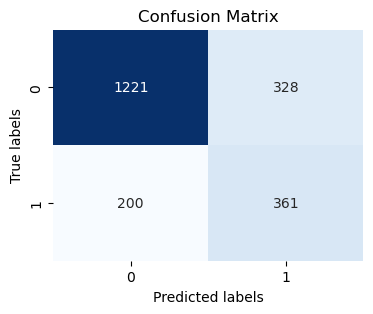

In [280]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_wgan)

In [281]:
# Error rate per class
print('Error rate per class:')
print(calculate_error_rate_per_class(y_test, y_pred_wgan))

# Error rate per class
print('\nF1 score per class:')
print(f1_score_per_class(y_test, y_pred_wgan))

Error rate per class:
[0.21174952 0.35650624]

F1 score per class:
[0.82222222 0.5776    ]


## Data Augmentation with SMOTE

In [282]:
# Get the indexes of discrete_columns in smote_df, excluding the last index
indexes = [df.columns.get_loc(col) for col in discrete_columns[:-1]]

In [283]:
# Instantiate SMOTE
smote = SMOTENC(categorical_features = indexes, random_state=2)

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.ravel())


In [284]:
print("Before OverSampling, counts of label 'No': {}".format(sum(y_train == 'No')))
print("Before OverSampling, counts of label 'Yes': {} \n".format(sum(y_train == 'Yes')))

print("After OverSampling, counts of label 'No': {}".format(sum(y_train_resampled == 'No')))
print("After OverSampling, counts of label 'Yes': {}".format(sum(y_train_resampled == 'Yes')))

Before OverSampling, counts of label 'No': 3614
Before OverSampling, counts of label 'Yes': 1308 

After OverSampling, counts of label 'No': 3614
After OverSampling, counts of label 'Yes': 3614


In [285]:
# Combine X_train_resampled and y_train_resampled into a single dataframe
smote_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
smote_df['Churn'] = y_train_resampled

# Filter out samples present in train_data
filtered_smote_df = smote_df[~smote_df.index.isin(train_data.index)]

# Reset the index of the resulting dataframe
filtered_smote_df.reset_index(drop=True, inplace=True)


In [286]:
filtered_smote_df.shape

(2306, 20)

In [5]:
# Perform KS Test
ks_results_df, average_ks_score = ks_test(filtered_smote_df, minority_train_data, continuous_columns, target_column)
print("KS Test Average Score:", average_ks_score)

KS Test Average Score: 0.9794735923571271


In [6]:
# Perform Chi-Square Test
chi2_test_results_df, average_p_value = chi2_test(filtered_smote_df, minority_train_data, discrete_columns, target_column)
print("Chi-Square Test Average P-value:", average_p_value)

Chi-Square Test Average P-value: 0.5963633262474193


In [289]:
# Encode categorical variables
X_train_resampled, _ = encode_categorical(X_train_resampled)

In [290]:
tree_model_smote = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, max_features = 'log2', random_state=42)
tree_model_smote.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       random_state=42)

In [291]:
# Make predictions on the testing data
y_pred_smote = tree_model_smote.predict(X_test)

# Calculate metrics
metrics_df_smote = calculate_metrics(y_test, y_pred_smote)
metrics_df_smote

,Score
Accuracy,0.735545
F1-score (macro),0.698227
Recall (macro),0.731201
Geometric Mean,0.731143
Cohen's Kappa,0.405672


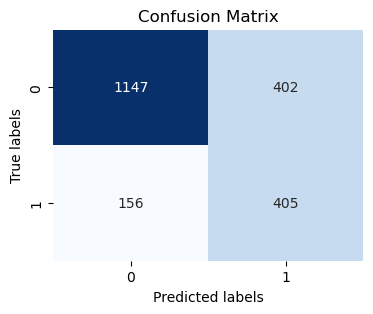

In [292]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_smote)

In [293]:
# Error rate per class
print('Error rate per class:')
print(calculate_error_rate_per_class(y_test, y_pred_smote))

# Error rate per class
print('\nF1 score per class:')
print(f1_score_per_class(y_test, y_pred_smote))

Error rate per class:
[0.25952227 0.27807487]

F1 score per class:
[0.80434783 0.59210526]


## Combining CTGAN and WGAN-GP results

In [294]:
# Sample 50% of the rows from each DataFrame
sampled_df_ctgan = synth_data_ctgan.sample(frac=0.5, random_state=42)
sampled_df_wgan = synth_data_wgan.sample(frac=0.5, random_state=42)

# Combine the sampled DataFrames
combined_df = pd.concat([sampled_df_ctgan, sampled_df_wgan], ignore_index=True)

In [295]:
train_data_combined = pd.concat([train_data, combined_df], ignore_index=True)

X_train_combined = train_data_combined.drop('Churn', axis=1)  # Features (all columns except the target variable)
y_train_combined = train_data_combined['Churn']  # Target variable

In [7]:
# Perform KS Test
ks_results_df, average_ks_score = ks_test(combined_df, minority_train_data, continuous_columns, target_column)
print("KS Test Average Score:", average_ks_score)

KS Test Average Score: 0.8841752490732415


In [8]:
# Perform Chi-Square Test
chi2_test_results_df, average_p_value = chi2_test(combined_df, minority_train_data, discrete_columns, target_column)
print("Chi-Square Test Average P-value:", average_p_value)

Chi-Square Test Average P-value: 0.6100798711628519


In [298]:
# Encode categorical variables
X_train_combined, _ = encode_categorical(X_train_combined)

In [299]:
tree_model_combined = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, max_features = 'log2', random_state=42)
tree_model_combined.fit(X_train_combined, y_train_combined)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       random_state=42)

In [300]:
# Make predictions on the testing data
y_pred_combined = tree_model_combined.predict(X_test)

# Calculate metrics
metrics_df_combined = calculate_metrics(y_test, y_pred_combined)
metrics_df_combined

,Score
Accuracy,0.733175
F1-score (macro),0.691813
Recall (macro),0.719355
Geometric Mean,0.718749
Cohen's Kappa,0.390929


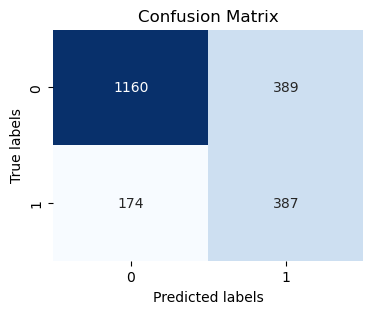

In [301]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_combined)

In [302]:
# Error rate per class
print('Error rate per class:')
print(calculate_error_rate_per_class(y_test, y_pred_combined))

# Error rate per class
print('\nF1 score per class:')
print(f1_score_per_class(y_test, y_pred_combined))

Error rate per class:
[0.25112976 0.31016043]

F1 score per class:
[0.80471731 0.578908  ]


## Filtering CTGAN + WGAN-GP results

In [303]:
# Combine the sampled DataFrames
combined_synth_df = pd.concat([synth_data_ctgan, synth_data_wgan], ignore_index=True)

In [304]:
combined_synth_df.shape

(4612, 20)

In [305]:
unique_diagnosis_values = combined_synth_df['Churn'].unique()
print(unique_diagnosis_values)

['Yes']


In [306]:
X_combined_synth = combined_synth_df.drop('Churn', axis=1)  # Features (all columns except the target variable)
y_combined_synth = combined_synth_df['Churn']  # Target variable


# Encode categorical variables
X_combined_synth, _ = encode_categorical(X_combined_synth)


# Combine features and target variable into a single DataFrame
combined_synth_df = pd.concat([X_combined_synth, y_combined_synth], axis=1)
#Shuffle
combined_synth_df = combined_synth_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = pd.concat([X_train, y_train], axis=1)

In [307]:
print(combined_synth_df.shape)

(4612, 20)


In [ ]:
# Define model parameters
model_params = {
    'criterion': 'entropy',
    'max_depth': 7,
    'max_features': 'log2',
    'random_state': 42
}

# Use the filter_noisy_samples function
filtered_df = filter_noisy_samples(generated_data=combined_synth_df,
                                        real_training_data=train_df,
                                        X_test=X_test,
                                        y_test=y_test,
                                        target_column='Churn',
                                        model_params=model_params,
                                        error_rate_threshold = 0.25) 


In [10]:
# Perform KS Test
ks_results_df, average_ks_score = ks_test(filtered_df, minority_train_data, continuous_columns, target_column)
print("KS Test Average Score:", average_ks_score)

KS Test Average Score: 0.86104253755847


In [11]:
# Perform Chi-Square Test
chi2_test_results_df, average_p_value = chi2_test(filtered_df, minority_train_data, discrete_columns, target_column)
print("Chi-Square Test Average P-value:", average_p_value)

Chi-Square Test Average P-value: 0.6002680654805919


In [311]:
filtered_df.shape

(1099, 20)

In [312]:
filtered_augmented_data = pd.concat([train_df, filtered_df], ignore_index=True)

In [313]:
X_train_filtered = filtered_augmented_data.drop('Churn', axis=1)  # Features (all columns except the target variable)
y_train_filtered = filtered_augmented_data['Churn']  # Target variable

In [314]:
tree_model_filtered = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, max_features = 'log2', random_state=42)
tree_model_filtered.fit(X_train_filtered, y_train_filtered)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       random_state=42)

In [315]:
# Make predictions on the testing data
y_pred_filtered = tree_model_filtered.predict(X_test)

# Calculate metrics
metrics_df_filtered = calculate_metrics(y_test, y_pred_filtered)
metrics_df_filtered

,Score
Accuracy,0.748815
F1-score (macro),0.712267
Recall (macro),0.745356
Geometric Mean,0.745319
Cohen's Kappa,0.432665


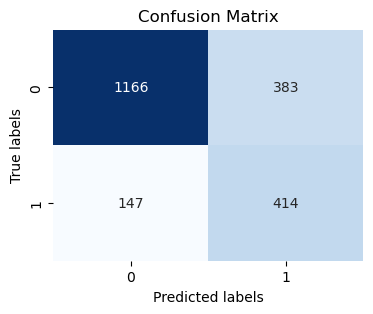

In [316]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_filtered)

In [317]:
# Error rate per class
print('Error rate per class:')
print(calculate_error_rate_per_class(y_test, y_pred_filtered))

# Error rate per class
print('\nF1 score per class:')
print(f1_score_per_class(y_test, y_pred_filtered))

Error rate per class:
[0.24725629 0.26203209]

F1 score per class:
[0.81481481 0.60972018]
